<a href="https://colab.research.google.com/github/takedatmh/toyama/blob/main/llama_finetune_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Llama 3.2 1B Fine-Tuning on Google Colab with QLoRA
This notebook is optimized to run within 15 minutes on T4 GPU with training visualization

## Step 1: Check GPU and Install Dependencies

In [ ]:
# Check GPU availability
!nvidia-smi
import torch
print(f"GPU Available: {torch.cuda.is_available()}")
print(f"GPU Name: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'No GPU'}")

Wed Jul  2 21:33:12 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# Install required packages
!pip install -q -U transformers datasets accelerate peft bitsandbytes trl matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 MB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 375.8/375.8 kB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 95.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Step 2: Login to Hugging Face (Required for Llama models)

In [ ]:
# Login to Hugging Face
!pip install -q huggingface_hub
from huggingface_hub import login

# Replace with your Hugging Face token
# Get it from: https://huggingface.co/settings/tokens
login(token="??_QITDVRlIekssKUEvPdlgHMhiJXXhdrnvi?")  # You need to replace this!

## Step 3: Import Libraries and Set Up Training Monitoring

In [ ]:
import torch
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    pipeline,
)
from peft import LoraConfig, PeftModel, prepare_model_for_kbit_training, get_peft_model
from datasets import load_dataset
from trl import SFTTrainer
import gc
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
from datetime import datetime

# For tracking training progress
training_losses = []
training_steps = []

## Step 4: Configure Model and Quantization

In [ ]:
# Model configuration
model_name = "meta-llama/Llama-3.2-1B"  # Smallest Llama 3 model
dataset_name = "yahma/alpaca-cleaned"  # Clean instruction dataset

# Configure 4-bit quantization for memory efficiency
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
)

print(f"Model: {model_name}")
print(f"Dataset: {dataset_name}")
print("Quantization: 4-bit (QLoRA)")

Model: meta-llama/Llama-3.2-1B
Dataset: yahma/alpaca-cleaned
Quantization: 4-bit (QLoRA)


## Step 5: Load Model and Tokenizer

In [ ]:
print("Loading model and tokenizer...")
start_time = time.time()

# Use a publicly available model as meta-llama/Llama-3.2-1B is gated
model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0" # Replace with a publicly available model
dataset_name = "yahma/alpaca-cleaned"  # Clean instruction dataset


bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
)

tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    trust_remote_code=True
)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

print(f"Model loaded in {time.time() - start_time:.2f} seconds")

Loading model and tokenizer...


config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

Model loaded in 15.19 seconds


## Step 6: Configure LoRA and Prepare Model

In [ ]:
# Prepare model for training
model = prepare_model_for_kbit_training(model)

# Configure LoRA
peft_config = LoraConfig(
    r=8,  # Low rank
    lora_alpha=16,
    target_modules=["q_proj", "v_proj", "k_proj", "o_proj"],
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM",
)

print("LoRA Configuration:")
print(f"  - Rank (r): {peft_config.r}")
print(f"  - Alpha: {peft_config.lora_alpha}")
print(f"  - Target modules: {peft_config.target_modules}")

LoRA Configuration:
  - Rank (r): 8
  - Alpha: 16
  - Target modules: {'q_proj', 'v_proj', 'k_proj', 'o_proj'}


## Step 7: Load and Prepare Dataset

In [ ]:
print("Loading dataset...")
dataset = load_dataset(dataset_name, split="train")

# Take only 500 samples for quick training
dataset = dataset.select(range(500))

# Format dataset for instruction tuning and tokenize
def format_instruction_and_tokenize(sample):
    instruction = f"""### Instruction:
{sample['instruction']}

### Input:
{sample['input']}

### Response:
{sample['output']}"""

    # Tokenize the instruction
    tokenized_input = tokenizer(instruction, truncation=True, padding="max_length", max_length=256, return_tensors="pt")

    return {"text": instruction, # Add the original text as 'text' column
            "input_ids": tokenized_input["input_ids"].squeeze(),
            "attention_mask": tokenized_input["attention_mask"].squeeze()}


dataset = dataset.map(format_instruction_and_tokenize, remove_columns=['instruction', 'input', 'output'])


print(f"Dataset loaded: {len(dataset)} samples")
print("\nSample data point (tokenized input_ids):")
print(dataset[0]['input_ids'][:20], "...")

Loading dataset...


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Dataset loaded: 500 samples

Sample data point (tokenized input_ids):
[1, 835, 2799, 4080, 29901, 13, 29954, 573, 2211, 25562, 363, 7952, 292, 9045, 29891, 29889, 13, 13, 2277, 29937] ...


## Step 8: Set Training Parameters

In [ ]:
# Training parameters optimized for speed
training_args = TrainingArguments(
    output_dir="./llama-3-1b-finetuned",
    num_train_epochs=1,  # Just 1 epoch for speed
    per_device_train_batch_size=4,
    gradient_accumulation_steps=2,
    gradient_checkpointing=True,
    optim="paged_adamw_32bit",
    logging_steps=5,  # Log more frequently for visualization
    save_strategy="epoch",
    learning_rate=2e-4,
    fp16=True,
    max_grad_norm=0.3,
    warmup_ratio=0.03,
    group_by_length=True,
    lr_scheduler_type="constant",
    report_to="none",  # Disable wandb/tensorboard for speed
    max_steps=50,  # Limit steps for 15-minute training
)

print("Training Configuration:")
print(f"  - Max steps: {training_args.max_steps}")
print(f"  - Batch size: {training_args.per_device_train_batch_size}")
print(f"  - Learning rate: {training_args.learning_rate}")
print(f"  - Effective batch size: {training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps}")

Training Configuration:
  - Max steps: 50
  - Batch size: 4
  - Learning rate: 0.0002
  - Effective batch size: 8


## Step 9: Initialize Trainer with Custom Callback for Visualization

In [ ]:
from transformers import TrainerCallback

class VisualizationCallback(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None and 'loss' in logs:
            training_losses.append(logs['loss'])
            training_steps.append(state.global_step)

            # Clear output and show updated plot
            clear_output(wait=True)

            # Create figure with training info
            fig, ax = plt.subplots(figsize=(10, 6))
            ax.plot(training_steps, training_losses, 'b-', linewidth=2)
            ax.set_xlabel('Training Steps', fontsize=12)
            ax.set_ylabel('Loss', fontsize=12)
            ax.set_title('Training Progress', fontsize=14)
            ax.grid(True, alpha=0.3)

            # Add training stats
            current_time = datetime.now().strftime("%H:%M:%S")
            stats_text = f"Step: {state.global_step}/{training_args.max_steps}\n"
            stats_text += f"Loss: {logs['loss']:.4f}\n"
            stats_text += f"Time: {current_time}"

            ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
                    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

            plt.tight_layout()
            plt.show()

            # Progress bar
            progress = state.global_step / training_args.max_steps
            bar_length = 50
            filled_length = int(bar_length * progress)
            bar = '█' * filled_length + '-' * (bar_length - filled_length)
            print(f"\rProgress: |{bar}| {progress*100:.1f}% Complete", end='\r')


# Initialize trainer
print("Initializing trainer...")
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    peft_config=peft_config,
    args=training_args,
    callbacks=[VisualizationCallback()],
)

print("Trainer initialized successfully!")

Initializing trainer...


Truncating train dataset:   0%|          | 0/500 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Trainer initialized successfully!


## Step 10: Start Training with Live Visualization

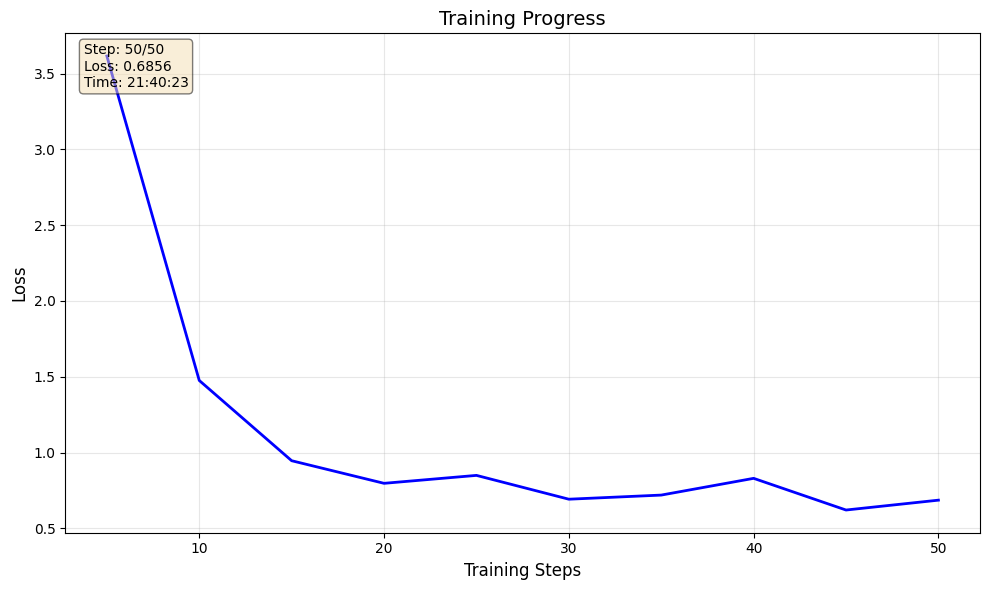

Step,Training Loss
5,3.616700
10,1.475600
15,0.945900
20,0.796700
25,0.849100
30,0.691900
35,0.719100
40,0.829600
45,0.620500
50,0.685600




 Training completed in 1.25 minutes!


In [ ]:
print("Starting training...")
print(f"Expected duration: ~10-12 minutes on T4 GPU")
print("="*50)

training_start_time = time.time()

# Train the model
trainer.train()

training_duration = time.time() - training_start_time
print(f"\n\n Training completed in {training_duration/60:.2f} minutes!")

## Step 11: Show Final Training Summary

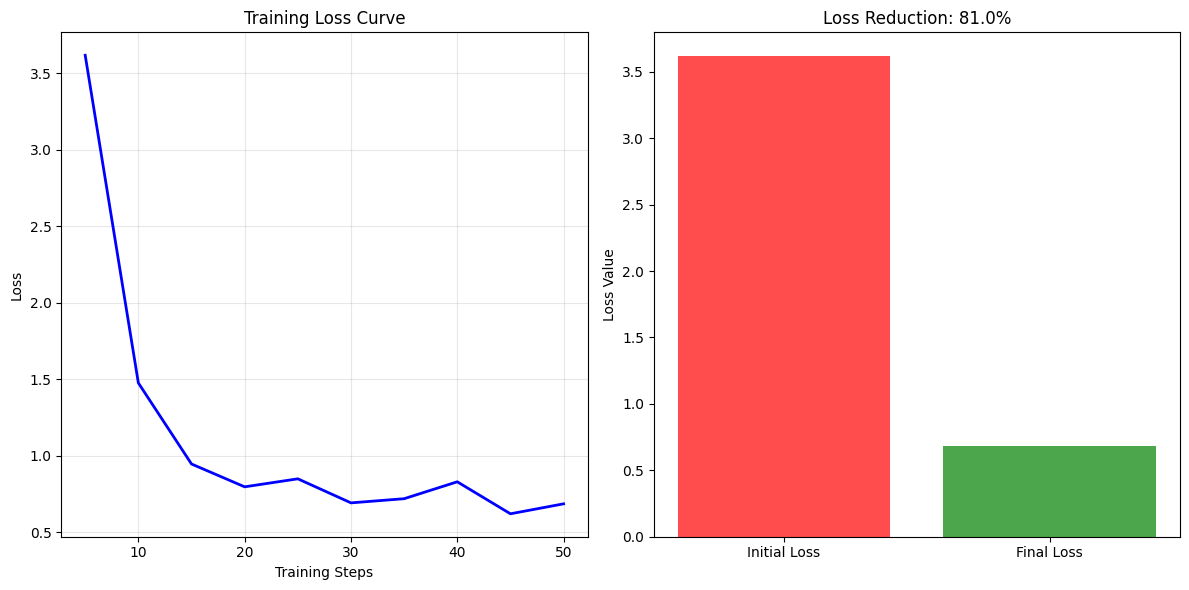

Training Summary:
  - Total steps: 10
  - Initial loss: 3.6167
  - Final loss: 0.6856
  - Loss reduction: 81.0%


In [ ]:
# Display final training plot
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(training_steps, training_losses, 'b-', linewidth=2)
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
# Show loss reduction
loss_reduction = (training_losses[0] - training_losses[-1]) / training_losses[0] * 100
plt.bar(['Initial Loss', 'Final Loss'], [training_losses[0], training_losses[-1]],
        color=['red', 'green'], alpha=0.7)
plt.ylabel('Loss Value')
plt.title(f'Loss Reduction: {loss_reduction:.1f}%')

plt.tight_layout()
plt.show()

print("Training Summary:")
print(f"  - Total steps: {len(training_steps)}")
print(f"  - Initial loss: {training_losses[0]:.4f}")
print(f"  - Final loss: {training_losses[-1]:.4f}")
print(f"  - Loss reduction: {loss_reduction:.1f}%")

## Step 12: Save the Fine-tuned Model

In [ ]:
print("Saving model...")
trainer.model.save_pretrained("./llama-3-1b-finetuned-lora")
tokenizer.save_pretrained("./llama-3-1b-finetuned-lora")
print("Model saved successfully!")

# Check saved files
!ls -la ./llama-3-1b-finetuned-lora/

Saving model...
Model saved successfully!
total 12884
drwxr-xr-x 2 root root    4096 Jul  2 21:40 .
drwxr-xr-x 1 root root    4096 Jul  2 21:40 ..
-rw-r--r-- 1 root root     816 Jul  2 21:40 adapter_config.json
-rw-r--r-- 1 root root 9034304 Jul  2 21:40 adapter_model.safetensors
-rw-r--r-- 1 root root     410 Jul  2 21:40 chat_template.jinja
-rw-r--r-- 1 root root    5108 Jul  2 21:40 README.md
-rw-r--r-- 1 root root     437 Jul  2 21:40 special_tokens_map.json
-rw-r--r-- 1 root root     951 Jul  2 21:40 tokenizer_config.json
-rw-r--r-- 1 root root 3619280 Jul  2 21:40 tokenizer.json
-rw-r--r-- 1 root root  499723 Jul  2 21:40 tokenizer.model


## Step 13: Test the Fine-tuned Model

In [ ]:
print("\n=== Testing the fine-tuned model ===")

# Clear memory
del trainer
gc.collect()
torch.cuda.empty_cache()

# Load model for inference
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto",
)

model = PeftModel.from_pretrained(model, "./llama-3-1b-finetuned-lora")


=== Testing the fine-tuned model ===


In [ ]:
# Test with multiple prompts
test_prompts = [
    """### Instruction:
What are the benefits of exercise?

### Input:


### Response:""",

    """### Instruction:
Explain machine learning in simple terms.

### Input:


### Response:""",

    """### Instruction:
Write a short poem about coding.

### Input:


### Response:"""
]

for i, test_prompt in enumerate(test_prompts):
    print(f"\n{'='*50}")
    print(f"Test {i+1}:")
    print(f"{'='*50}")

    inputs = tokenizer(test_prompt, return_tensors="pt").to("cuda")
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=100,
            temperature=0.7,
            do_sample=True,
            top_p=0.95,
            pad_token_id=tokenizer.eos_token_id,
        )

    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    print(response)


Test 1:
### Instruction:
What are the benefits of exercise?

### Input:


### Response:
Exercise is a highly beneficial activity that can have a positive impact on your overall health and wellbeing. Some of the benefits of exercise include:

1. Reduces stress: Regular exercise can help reduce stress levels by releasing endorphins, which are natural mood boosters.

2. Increases energy: Exercise boosts energy levels and helps you to feel more energetic, which can help you to overcome challenges

Test 2:
### Instruction:
Explain machine learning in simple terms.

### Input:


### Response:
Machine learning is a branch of artificial intelligence that aims to improve the accuracy of predictive algorithms by allowing computers to learn from data without being explicitly programmed. In essence, machine learning is the process of automatically learning from data without being explicitly programmed. It is a subset of artificial intelligence that involves the use of algorithms to analyze data i

## Step 14: Download Fine-tuned Model (Optional)

In [ ]:
# Create a zip file of the fine-tuned model for download
!zip -r llama-3-1b-finetuned-lora.zip ./llama-3-1b-finetuned-lora/

# Download the model
from google.colab import files
print("Downloading fine-tuned model...")
files.download('llama-3-1b-finetuned-lora.zip')

  adding: llama-3-1b-finetuned-lora/ (stored 0%)
  adding: llama-3-1b-finetuned-lora/adapter_config.json (deflated 55%)
  adding: llama-3-1b-finetuned-lora/README.md (deflated 66%)
  adding: llama-3-1b-finetuned-lora/special_tokens_map.json (deflated 73%)
  adding: llama-3-1b-finetuned-lora/adapter_model.safetensors (deflated 8%)
  adding: llama-3-1b-finetuned-lora/chat_template.jinja (deflated 60%)
  adding: llama-3-1b-finetuned-lora/tokenizer.json (deflated 85%)
  adding: llama-3-1b-finetuned-lora/tokenizer_config.json (deflated 69%)
  adding: llama-3-1b-finetuned-lora/tokenizer.model (deflated 55%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##  Congratulations!

You've successfully fine-tuned Llama 3.2 1B model on Google Colab!

### What you've accomplished:
-  Fine-tuned a 1B parameter model in under 15 minutes
-  Used QLoRA for memory-efficient training
-  Trained on 500 instruction-following examples
-  Saved LoRA adapters (~10MB) that can be easily shared

### Next steps:
1. Try different datasets or increase training samples
2. Experiment with different LoRA ranks (r parameter)
3. Fine-tune for specific tasks (coding, creative writing, etc.)
4. Deploy your model using the saved LoRA adapters